# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="weights")
        self.b = tf.Variable(tf.zeros([out_features]), name="biases")

    def __call__(self, x):
      y = tf.matmul(x, self.w) + self.b
      return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Выходной слой
    self.layer_outputs = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    x = self.layer_1(x)

    x = self.layer_2(x) 

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов

    x = self.layer_outputs(x)
    return tf.nn.softmax(x)

In [5]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [6]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
  # Создадим оптимизируемых список параметров
  trainable_variables = neural_net.trainable_variables

  # Вычислим по ним значение градиента
  gradients = g.gradient(loss, trainable_variables)
    
    # Модифицируем параметры
  optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
from tensorflow.python.ops.nn_ops import L2Loss
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Обновляем веса нейронной сети
  train(neural_net, batch_x, batch_y)
    
  if step % display_step == 0:
    pred = neural_net(batch_x)

    loss = cross_entropy(pred, batch_y)
    acc = accuracy(pred, batch_y)

    accuracy_history.append(acc)
    loss_history.append(loss)

    print(f"Training epoch: {step}, Loss: {loss}, Accuracy: {acc}")

Training epoch: 100, Loss: 575.8477172851562, Accuracy: 0.125
Training epoch: 200, Loss: 563.4215087890625, Accuracy: 0.21875
Training epoch: 300, Loss: 528.713134765625, Accuracy: 0.33984375
Training epoch: 400, Loss: 511.66436767578125, Accuracy: 0.3984375
Training epoch: 500, Loss: 495.2760314941406, Accuracy: 0.4921875
Training epoch: 600, Loss: 492.4902038574219, Accuracy: 0.49609375
Training epoch: 700, Loss: 472.00732421875, Accuracy: 0.55859375
Training epoch: 800, Loss: 475.4298400878906, Accuracy: 0.55078125
Training epoch: 900, Loss: 463.046142578125, Accuracy: 0.56640625
Training epoch: 1000, Loss: 472.8702392578125, Accuracy: 0.58203125
Training epoch: 1100, Loss: 456.2889404296875, Accuracy: 0.59765625
Training epoch: 1200, Loss: 455.7967529296875, Accuracy: 0.6484375
Training epoch: 1300, Loss: 457.36798095703125, Accuracy: 0.6640625
Training epoch: 1400, Loss: 443.8818359375, Accuracy: 0.7265625
Training epoch: 1500, Loss: 445.806640625, Accuracy: 0.6875
Training epoch:

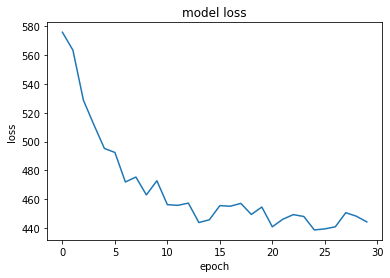

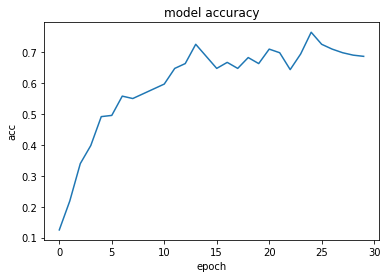

In [8]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.figure()
plt.plot(accuracy_history)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

In [9]:
# Вычислите точность обученной нейросети

pred = neural_net(x_test)
print(f"Test Accuracy: {accuracy(pred, y_test)}")

Test Accuracy: 0.7310000061988831


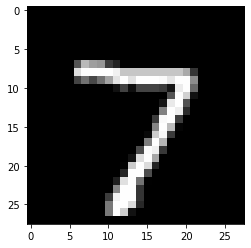

Model prediction: 7


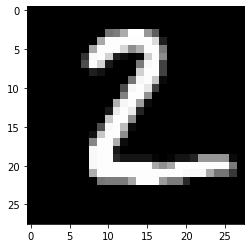

Model prediction: 2


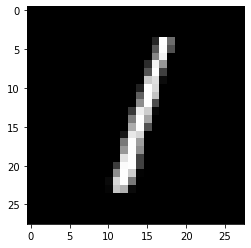

Model prediction: 1


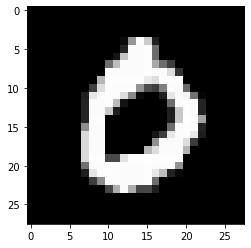

Model prediction: 2


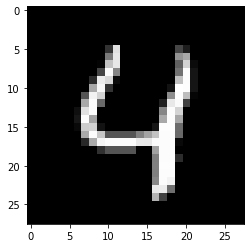

Model prediction: 6


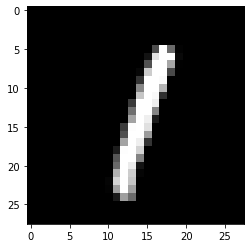

Model prediction: 1


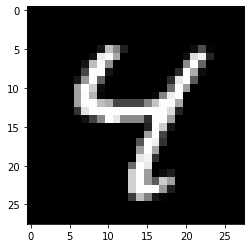

Model prediction: 4


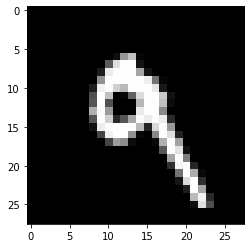

Model prediction: 9


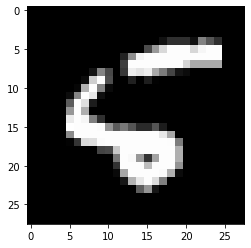

Model prediction: 6


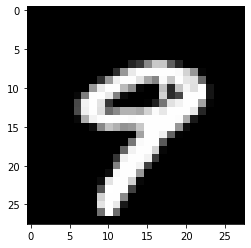

Model prediction: 9


In [12]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?
n_images = 10
test_images = x_test[:n_images]
predictions = neural_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print(f"Model prediction: {np.argmax(predictions.numpy()[i])}")